# What I discovered from analysing 10,000 medium posts on Towardsdatascience.

### 9 Tips on how to increase readers engagement, earn more claps and views.

In [40]:
# Import various libraries

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import warnings
import matplotlib.gridspec as gridspec
import re
warnings.filterwarnings('ignore')
from nltk import word_tokenize 
from nltk.util import ngrams
import glob as glob
import os

In [41]:
# set axis background
sns.set_style('darkgrid')
sns.cubehelix_palette(light=1,as_cmap=True);

In [42]:
# list all files in the current directory
glob.glob('data/*')

['data\\mydata1.json',
 'data\\mydata2.json',
 'data\\mydata3.csv',
 'data\\mydata4.json']

In [43]:
# load all data files
dataframe1 = pd.read_json('data/mydata1.json')
dataframe2 = pd.read_json("data/mydata2.json")
dataframe3 = pd.read_csv("data/mydata3.csv")
dataframe4 = pd.read_json("data/mydata4.json")


# combine the all dataframes
df = pd.concat([dataframe1,dataframe2,dataframe3,dataframe4],ignore_index=True)


In [44]:
# pd.DataFrame(np.unique(df),df=columns)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13160 entries, 0 to 13159
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   header        12653 non-null  object
 1   sub_header    10901 non-null  object
 2   article       13160 non-null  object
 3   tag           13149 non-null  object
 4   clap          13051 non-null  object
 5   biography     13160 non-null  object
 6   date_publish  13160 non-null  object
 7   read_time     13160 non-null  object
dtypes: object(8)
memory usage: 822.6+ KB


* We have 8 different features or fields.
* There are $13160$ data entries.
* All features are object data types
* We have $3.9$%, $17.2$%, $0.08$%, $0.83$% of `header`,`sub_header`,`tag` and `clap` data missing respectively.

In [46]:
df.describe()

,header,sub_header,article,tag,clap,biography,date_publish,read_time
count,12653,10901,13160,13149,13051,13160,13160,13160
unique,12568,10735,13151,12552,860,4565,289,49
top,Understanding the Central Limit Theorem,NLP Papers Summary is a series where I summari...,On Reproducibility Erik Kristofer Anderson Jan...,[],6,Your home for data science. A Medium publicati...,"Jun 15, 2020",6 min read
freq,4,19,2,113,161,335,98,2119


* The total reading time is $13,160$ minutes
* The articles under study were published on $289$ unique dates.
* Jun 15,2020 was observed as the date with the highest posts of about 98.

# Lets do some preprocessing

## sub_header

In [47]:
# We will perform analysis on none sub-headers later
df['sub_header'] = df['sub_header'].apply(lambda x:'N/A' if pd.isna(x) else x)

In [48]:
## Null and Duplicates rows

In [49]:
# drop all nan values
df = df.dropna()

# Take out list from tag
df['tag'] = df['tag'].apply(lambda x:'##'.join(x))

# drop duplicates rows
df = df.drop_duplicates()

# reverse tag to original
df['tag'] = df['tag'].apply(lambda x:x.split('##'))


## clap 

You could see that some of the strings contain `.` and `K`. 

This is used by medium to shorten long figures.
`K` means $1000$  
We will therefore replace the dot sign with empty `''` string.

In [50]:
df['clap'][96]

'1.7K'

##### A function to format number of claps

In [51]:

def format_clap(data):
    if '.' in data:
        data = data.replace('K','00').replace('.','')
    else:
        data = data.replace('K','000')
    return data

# claps before formatting
print('Claps before',df['clap'][800])

# formatting figures
df['clap'] = df['clap'].apply(lambda x: x if pd.isna(x) else format_clap(x))

# fill the none values with zero
df['clap'] = df['clap'].fillna(0).astype('int')

print('Claps after',df['clap'][800])


Claps before 2.8K
Claps after 2800


## tag

* The maximum number of tags allowed on a medium post is $5$, but we have up to $4159$ tags with the average being $16$ in some posts. So lets filter them.  

* Also per manual observation of the data, the last five tags are the legitimate tags, therefore lets take the last five tags in the list


In [52]:
# get the maximum number of tags
print('Maximum number of tags',df['tag'].apply(lambda x:len(x)).max())
print('Average number of tags',np.average(df['tag'].apply(lambda x:len(x))))

Maximum number of tags 4159
Average number of tags 16.247128270580728


In [53]:
# select only the last five tags
df['tag'] = df['tag'].apply(lambda x:x[-5:])

Now with our domain knowledge, a tag should contain atmost 3 words.  
Hence, we will take out all the tags with more than 3 words

In [54]:
# take out all tags with four or more words
df['tag'] = df['tag'].apply(lambda x:[item for item in x if (len(item.split()) <= 3)])

# read_time
* We will extract the values and change the data type to integer

In [55]:
df['read_time'] = df['read_time'].apply(lambda x:x.split()[0])

## Formatting Datatypes

In [56]:
# change from object type to integer type
df['clap'] = df['clap'].astype('int')

## Some helper functions

In [57]:
# Lets define a function to annotate our barplots
def annotate_bar(ax,label=None,percentage=None):
    if percentage and not label:
        for bar in ax.patches:
            ax.annotate(format(bar.get_height(), '.2f')+'%',
                           (bar.get_x() + bar.get_width() / 2,
                            bar.get_height()), ha='center', va='center',
                           size=15, xytext=(0, 8),
                           textcoords='offset points')
    elif not percentage and not label:
        for bar in ax.patches:
            ax.annotate(format(bar.get_height(), '.2f'),
                           (bar.get_x() + bar.get_width() / 2,
                            bar.get_height()), ha='center', va='center',
                           size=15, xytext=(0, 8),
                           textcoords='offset points')
    else:
        for bar,lab in zip(ax.patches,label):
            ax.annotate(str(lab) +'%',
                           (bar.get_x() + bar.get_width() / 2,
                            bar.get_height()), ha='center', va='center',
                           size=15, xytext=(0, 8),
                           textcoords='offset points')

# Before we start, lets do a short statistical analysis on the number of claps

### Percentile distribution

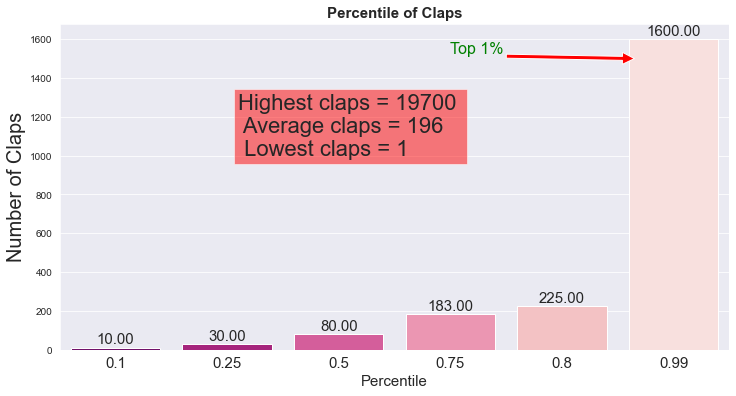

In [58]:
# average number of claps
avg_clap = int(np.round(df['clap'].mean()))
min_clap = int(np.round(df['clap'].min()))
max_clap = int(np.round(df['clap'].max()))

# percentile distribution
perc = df['clap'].quantile([0.1,0.25,0.5,0.75,0.80,0.99])
fig,ax = plt.subplots(figsize=(12,6))

axs = sns.barplot(perc.index.values,perc.values,palette='RdPu_r')
ax.set_xlabel('Percentile',fontdict={'fontsize':15})
ax.set_ylabel('Number of Claps',fontdict={'fontsize':20})
ax.set_title('Percentile of Claps',fontdict={'fontsize':15,'fontweight':'bold'})
plt.text(1.1, 1000, 'Highest claps = {} \n Average claps = {} \n Lowest claps = {}'.format(max_clap,avg_clap,min_clap), 
         fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.5))
plt.setp(ax.get_xticklabels(),fontsize = 15)

plt.annotate('Top 1%', xy = (4.65, 1500), 
             fontsize = 16, xytext = (3, 1528), 
             arrowprops = dict(facecolor = 'red'),
             color = 'g');
plt.savefig('firstfig.jpg',dpi=1200)
annotate_bar(axs)    

* The top $1$% medium post must earn at least 1600 claps.
* The average number of claps for all articles is 196.
* $50$% of the articles earn $80$ which is $116$ lesser than the average claps.
* In order to be part of the top $20$%, you have to earn atleast $225$ claps on your post.

### Consistency of articles

In [313]:
# # df.drop('tag',axis=1).drop_duplicates()
# def join_list(row):
#     row = ''.join(row)
#     return row

# df1['tag'] = df1['tag'].apply(lambda x:'##'.join(x))
# tag_list = list()

# for val in list(df['tag'].dropna()):
# #     tag_list.append(join_list(value))
#     tag_list.append(''.join(val))
# df1.drop_duplicates()


# reg1 = reg.match(df1['article'][5])
# # df1['article'][5]
# reg.group()

# matches = re.findall(r'(?:(?<=^)|(?<=[^.]))\s+([A-Z][a-z]+)', text1)

# re.match(r'.*(?:)[a-zA-Z]*\s\d{1,2}[,]\s\d{2,4}\s',df1['article'][5],re.I).group()

In [59]:
# get the author's information from the first line
reg1 = re.compile('.*(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{1,2}[,]\s\d{2,4}\s',re.I)
df['author'] = df['article'].apply(lambda x:reg1.match(x).group().strip())
df['author'] = df['author'].apply(lambda x:(x[-50:-12]).strip())

# create a column for authors
df['author'] = df['author'].apply(lambda x:x.split()[-1] if len(x.split()[-1])>1 else x.split()[-2])

In [60]:
top_20_val = 225
df['top_20'] = (df['clap'] >= top_20_val)
temp = df.groupby('author',as_index=False).sum()
total_authors = temp.shape[0]


my_dic = dict()

for num in range(1,11):
    tt = np.sum(temp['top_20'] >=num)
    perc = np.round((tt/total_authors)*100,2)
    my_dic[tt] = perc

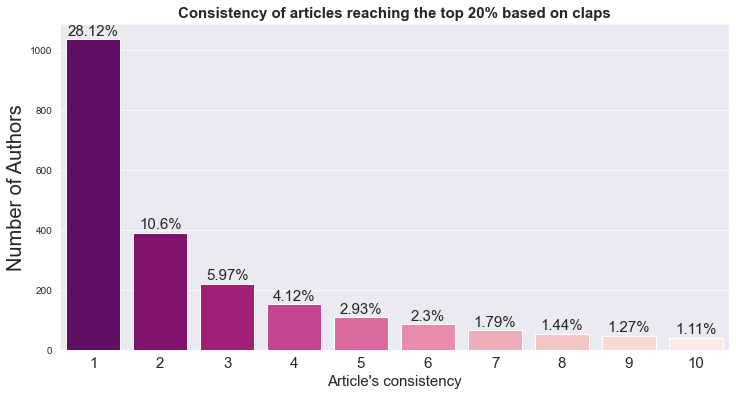

In [62]:
fig,ax = plt.subplots(figsize=(12,6))

axs = sns.barplot(np.arange(len(my_dic))+1,list(my_dic.keys()),palette='RdPu_r')

ax.set_xlabel("Article's consistency",fontdict={'fontsize':15})
ax.set_ylabel('Number of Authors',fontdict={'fontsize':20})
ax.set_title('Consistency of articles reaching the top 20% based on claps',fontdict={'fontsize':15,'fontweight':'bold'})

plt.setp(ax.get_xticklabels(),fontsize = 15)

annotate_bar(axs,list(my_dic.values()))
plt.savefig('consistence.jpg',dpi=1200)

* From the above, only $28.12$% of the authors have atleast $1$ of their articles reaching $225$ ( which is the top 20% clap).

* Less than half of those that have their initial article reaching the top 20% have their second one reaching as well.

**So the rate at which an author's second article reaching the top 20% mark is approximately 11%, which is not encouraging.**

# Lets begin with univariate analysis

In this section of the work, we will be asking ourselves a couple of questions and then derive our answers from the data in use.

# WHAT CAN WE LEARN FROM THE HEADERS OF OUR ARTICLES?

### a. What are the most used _keywords_ in headers and sub headers, and which of these keywords are often used in articles with great number of claps?

### b. Does having any of the top 20 keywords within your `header` and `sub_header` increase the  number of claps on your article?
### c. What are the most used two keywords combination in our headers and which ones drive more claps?
### d. What of an articles with or without a sub-header?
### Conclusion for headers

### a. What is the most used _keywords_ writers use in headers and sub headers and among them which ones attracts the highest average claps?
hypothesis:
* 'data','science' and 'how' are anticipated to appear in the frequently used keywords

In [63]:
# stopwords are the irrelevants and frequently occuring words in english
stop_words = stopwords.words('english')

# join all main headers  and sub headers into a single list
header = ' '.join(df['header']).lower()
sub_header = ' '.join(df['sub_header']).lower()

# eliminate stopwords from the headers
header = [word for word in header.split() if word not in stop_words]
sub_header = [word for word in sub_header.split() if word not in stop_words]

# eliminate non alph-numerics from the tokens
header = [word for word in header if word.isalnum()]
sub_header = [word for word in sub_header if word.isalnum()]


# calculate words frequency; the occurrances of keywords used in headers
head_freq_dict = nltk.FreqDist(header)
sub_freq_dict = nltk.FreqDist(sub_header)

# change from dictionary to list
head_freq_list = [(word,freq) for word,freq in head_freq_dict.items()]
sub_freq_list = [(word,freq) for word,freq in sub_freq_dict.items()]

# sort the keywords in descending order of magnitude
head_sorted_keywords = sorted(head_freq_list,key=lambda x:x[1],reverse=True)
sub_sorted_keywords = sorted(sub_freq_list,key=lambda x:x[1],reverse=True)


# Pick the most frequent 10 keywords
head_freq_20 = dict(head_sorted_keywords[:20])
sub_freq_20 = dict(sub_sorted_keywords[:20])
sns.set_style('whitegrid')

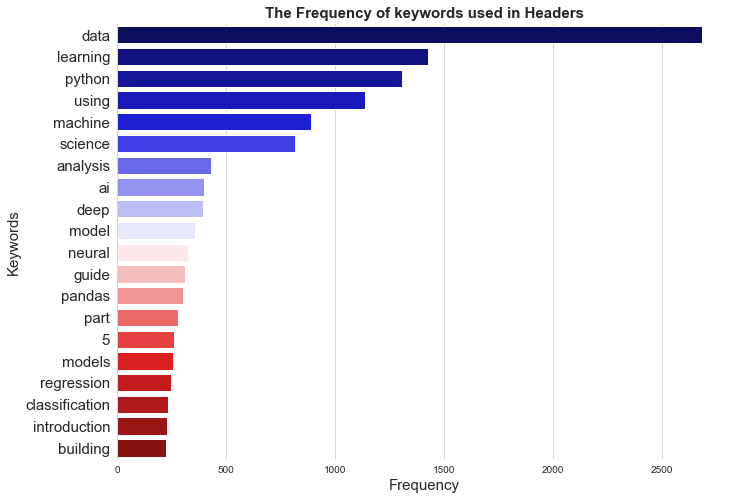

In [67]:
fig,ax = plt.subplots(figsize=(11,8))
X = list(head_freq_20.keys())
Y = list(head_freq_20.values())
ax = sns.barplot(x=Y,y=X,orient='h',palette='seismic')

ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.grid(False,which='minor',axis='x')

plt.title('The Frequency of keywords used in Headers',fontdict={'fontsize':15,'fontweight':'bold'});
plt.xlabel('Frequency',fontdict={'fontsize':15})
plt.ylabel('Keywords',fontdict={'fontsize':15});
plt.setp(ax.get_yticklabels(),fontsize=15);

plt.savefig('freq_keywords.jpg',dpi=1200,bbox_inches='tight')

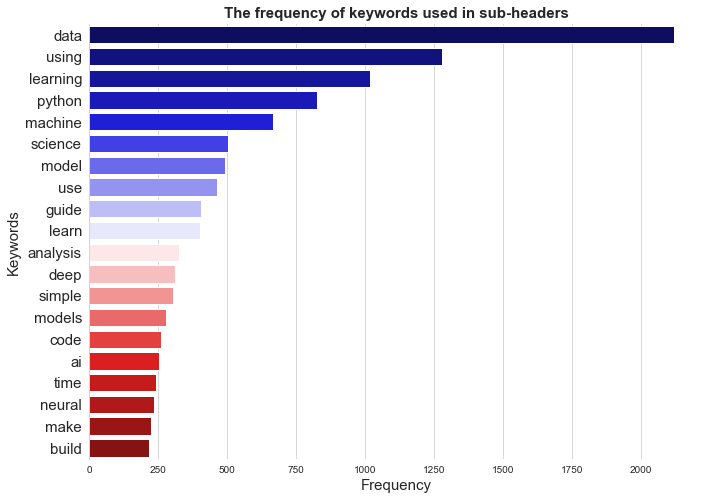

In [69]:
# sns.set_style('darkgrid')
fig,ax = plt.subplots(figsize=(11,8))
X = list(sub_freq_20.keys())
Y = list(sub_freq_20.values())
sns.barplot(x=Y,y=X,orient='h',palette='seismic');

ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('The frequency of keywords used in sub-headers',fontdict={'fontsize':15,'fontweight':'bold'})
plt.xlabel('Frequency',fontdict={'fontsize':15})
plt.ylabel('Keywords',fontdict={'fontsize':15})
plt.setp(ax.get_yticklabels(),fontsize=15)
plt.savefig('sub-headers.jpg',dpi=1200,bbox_inches='tight')

### The following observations are made from the above plots
* The top five keywords used in both the main and sub-headers are `data`,`learning`, `python`, `using` and `machine`.
* We also noticed ai,time,neural make and build as the least used keywords.  
Before we jump into a conclusion on the keywords, lets see which of them drives the highest claps to determine the ones to priotize.

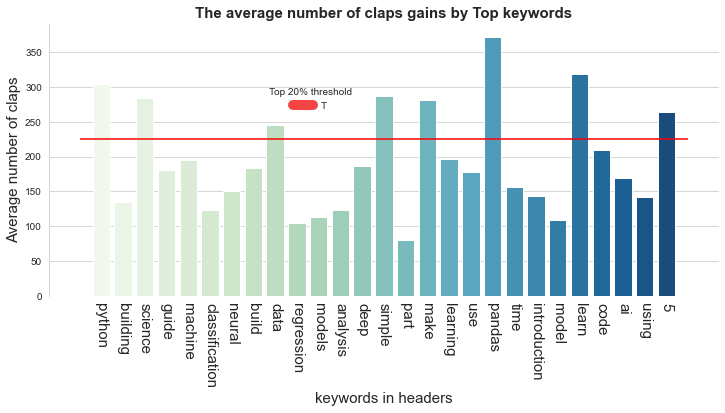

In [115]:
# change the dictionary to list and concatenate them
keywords = set(list(head_freq_20.keys()) + list(sub_freq_20.keys()))

# create empty dictionary
kw_avg = dict()

for word in keywords:
#     loop through the keywords, and with each word, find the headers with that keywords
    boolean = df.apply(lambda x: any([word in x['header'].lower().split()] or [word in x['sub_header'].lower().split()]),axis=1)
    temp = df[boolean]
#     calculate the average claps of the entries having that keywords in its header and store it in a dictionary
    kw_avg[word] = np.int(np.average(temp['clap']))


# Lets do the plotting
fig,ax = plt.subplots(figsize=(12,5))
sns.barplot(x=list(kw_avg.keys()),y=list(kw_avg.values()),palette='GnBu')
plt.xlabel('keywords in headers',fontdict={'fontsize':15})
plt.ylabel('Average number of claps',fontdict={'fontsize':15});

ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('The average number of claps gains by Top keywords',fontdict={'fontsize':15,'fontweight':'bold'});
plt.setp(ax.get_xticklabels(),fontsize=15,rotation=-90);

plt.hlines(y=225,xmin=-1,xmax=27,color='r');
plt.legend('Top 20% mark')

axes = plt.gca()

from matplotlib.lines import Line2D

cmap = plt.cm.coolwarm

custom_lines = [Line2D([0], [0], color='#f64444', lw=10,pickradius=0)]


axes.legend(custom_lines, 'Threshold',title='Top 20% threshold',
           loc='best', bbox_to_anchor=(0.04, 0.1, 0.7, 0.7),
            frameon=False,fontsize='medium')
plt.savefig('plot4.jpg',dpi=1200,bbox_inches='tight');

* It appears that among the top 20 most used keywords, only 8 appear in the headers of the top 20% articles.
These are:
    * pandas
    * 5 (really??)
    * Simple
    * Science
    * Learn
    * make
    * data
    * python
    
**Therefore You can consider writing about these keywords or priortizing these keywords in the headers of your next post**

In [137]:
# df[(df['header'].apply(lambda x:'5' in x))].iloc[8].iloc[0]

'Top 5 Open Data Science Competitions with Cash Prizes'

### b. Does having any of the top 20 keywords within your `header` and `sub_header` increase the  number of claps on your article?

### Lets group the articles in two categories.
1. The one with a header or sub-header containing any of the top 20 keywords
2. The one without any of the top 20 keywords in them.

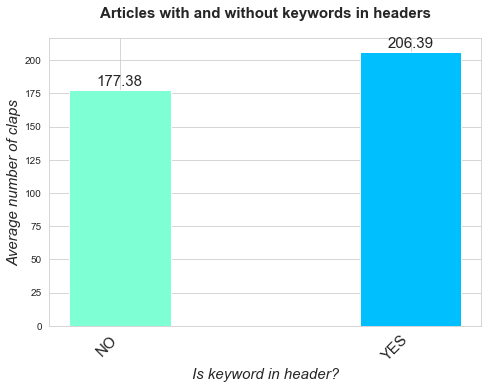

In [144]:
# loop through each header and sub-header
# if any of the keywords are found in either the header or the sub-header, return True else return false
boolean = df.apply(lambda x: any([word in keywords for word in x['header'].lower().split()] or [word in keywords for word in x['sub_header'].lower().split()]),axis=1)
# create a new column with the boolean values
df.loc[:,'in_headers'] = boolean.values

h_df = df.groupby('in_headers').mean().round(2)



# A function to create barplot
def labelled_barplot(df,label1=None,label2=None,title=None,x_label=None,y_label=None):
    """This return a barplot with a well labelled axis"""
#     getting the x values from the length of dataframe
    x = np.arange(df.shape[0])
    
#     index of the df as a label
    labels = ['NO','YES']
    fig  = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    width = 0.35

    ret1 = ax.bar(x,df.iloc[:,0],width=width,color=['aquamarine','deepskyblue'])

    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.set_title(title,fontsize=15,fontweight='bold',fontdict={'fontsize':15},pad=20)
    ax.set_ylabel(y_label,fontstyle='italic',fontdict={'fontsize':15})
    ax.set_xlabel(x_label,fontstyle='italic',fontdict={'fontsize':15})

    ax.grid(True,which='minor',axis='y')

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=15)

    autolabel(ret1)
    plt.setp(ax.get_xticklabels(),rotation=45,ha='right',fontsize=15);
    plt.savefig('plot5.jpg',dpi=1200,bbox_inches='tight');
#     plt.show()
    
    
# creating barplot with the `rate_barplot` function
labelled_barplot(h_df,title='Articles with and without keywords in headers',
                 x_label='Is keyword in header?',y_label='Average number of claps')



* The average number of claps for articles with and without any of the top 20 keys are $206.39$ and $177.38$ respectively.
* This confirms the fact that having at least one of the top keywords in your header mays give you an edge.

### c. What are the most used two keywords combination in our headers and which ones drive more claps?


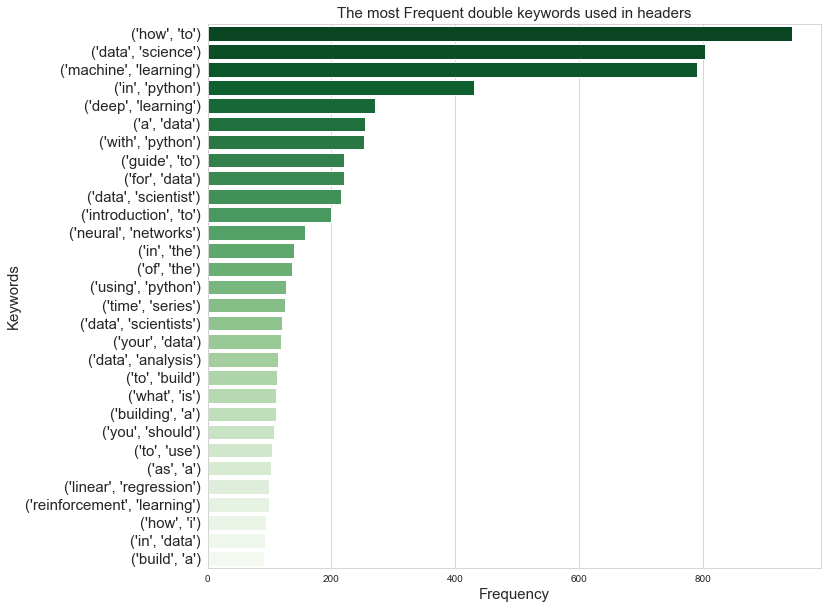

In [146]:
h1 = df['header'].str.lower().str.replace(',','')
h1 = h1.apply(lambda word: [w for w in word.split() if w.isalnum()])

h1 = h1.apply(lambda x:list(ngrams(x,2)))

gaint_list = list()

for tuples in list(h1):
    for tup in tuples:
        gaint_list.append(tup)


bigram_freq = nltk.FreqDist(gaint_list)



bigram_freq = [(word,freq) for word,freq in bigram_freq.items()]

bigram_freq = sorted(bigram_freq,key=lambda x:x[1],reverse=True)


bigram_freq_top20 = dict(bigram_freq[:30])
# # head_freq_10
# bigram_freq_top10

fig,ax = plt.subplots(figsize=(11,10))
X = [str(x) for x in list(bigram_freq_top20.keys())]
Y = list(bigram_freq_top20.values())

sns.barplot(x=Y,y=X,orient='h',palette='Greens_r')
plt.title('The most Frequent double keywords used in headers',fontdict={'fontsize':15});
plt.xlabel('Frequency',fontdict={'fontsize':15})
plt.ylabel('Keywords',fontdict={'fontsize':15});
ax = plt.gca()
plt.setp(ax.get_yticklabels(),fontsize=15);
plt.savefig('plot6.jpg',dpi=1200,bbox_inches='tight');


* Among the twenty most frequent bigrams( double keywords), the topmost four are `how to`, `data science`, `machine learning` and `in python`
* The last four are `build a`,`in data`,`how i` and `reinforcement learning`

#### Now lets see how these combination contributes to claps

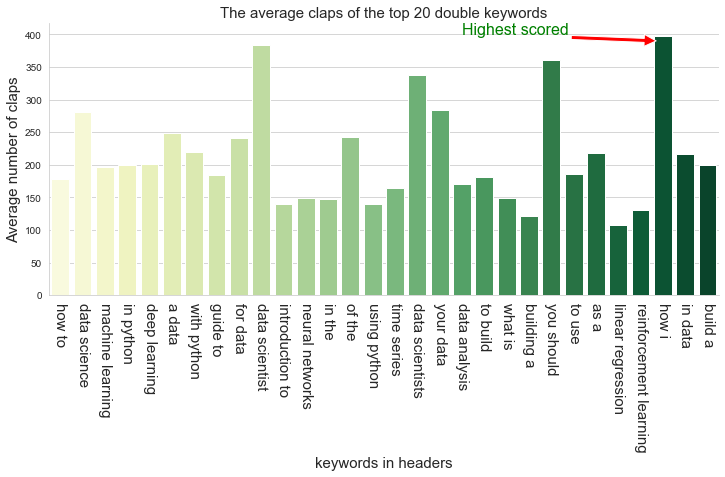

In [147]:
# change the dictionary to list and concatenate them
top_bigrams = [word[0]+' '+word[1] for word in list(bigram_freq_top20.keys())]

# create empty dictionary
kw_avg = dict()
for word in top_bigrams:
#     loop through the keywords, and with each word, find the headers with that keywords
    boolean = df.apply(lambda x: any([word in x['header'].lower()] ),axis=1)
    temp = df[boolean]
#     calculate the average claps of the entries having that keywords in its header and store it in a dictionary
    kw_avg[word] = np.int(np.average(temp['clap']))


# Lets do the plotting
fig,ax = plt.subplots(figsize=(12,5))
sns.barplot(x=list(kw_avg.keys()),y=list(kw_avg.values()),palette='YlGn')
plt.xlabel('keywords in headers',fontdict={'fontsize':15})
plt.ylabel('Average number of claps',fontdict={'fontsize':15});
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('The average claps of the top 20 double keywords',fontdict={'fontsize':15});
plt.setp(ax.get_xticklabels(),fontsize=15,rotation=-90)

plt.annotate('Highest scored', xy = (26.7, 390), 
             fontsize = 16, xytext = (18, 400), 
             arrowprops = dict(facecolor = 'red'),
             color = 'g')
plt.savefig('plot7.jpg',dpi=1200,bbox_inches='tight');


* `How i` have the highest average number of claps followed by `data scientist`, `you should` then the rest.
> If you could recall, **'how i'** was recorded as one of the least used bi-keywords, yet it attracts the highest average claps.

_Interesting,right?_

**'How I'** is usually used to tell stories, and a study conducted by a neuroscientist `Uri Hasson`, concluded that storytelling causes the neurons of an audience to sync with the storyteller's brain.  

Also humans relate to tales, therefore telling them is a fascinating method to present. Stories engross the listener, elicit empathy, build trust, and inspire action.

[Read more here](https://virtualspeech.com/blog/tell-story-delivering-presentation)

Examples of `how i` stories are:  
    * `How I Became a Data Analyst by Optimizing the Right Place and Time`  
    * `How I got a Data Science Job in Canada`  
    * `How I published an app and model to classify 85 snake species (and how you can too)`

All the above triggers readers curiousity to know more :)

### d. Is having a sub-header also help me earn more claps?
 * It is recorded that $16$% of the articles with main headers does not have sub-headers, now lets see if having a sub-header too can put you in a good position for more claps?

In [45]:
# df['sub_header'].apply(lambda x:(x !='N/A'))
# (df['sub_header'] == 'N/A').value_counts(normalize=True)

In [148]:
# return True if having a sub-header else False
boolean = df['sub_header'].apply(lambda x:(x !='N/A'))

# get articles with sub-header
with_sub_h = df[boolean]
# get articles without a sub-header
without_sub_h = df[~boolean]

# pick the same number of samples for both with or without sub-header
avg_subh = with_sub_h['clap'].mean()
avg_no_subh = without_sub_h['clap'].mean()
print('Average number of claps for articles with sub-headers is {}'.format(np.around(avg_subh)))
print('Average number of claps for articles without sub-headers is ',np.around(avg_no_subh))

Average number of claps for articles with sub-headers is 203.0
Average number of claps for articles without sub-headers is  158.0


* It is observed from the above that the average claps for articles with sub-header is more than the articles having no sub-headers.

> This is because, articles with the main header and a decriptive sub-header appears more in it's intended readers.
Hence
* There is an increase in user outreach and clickthrough.  
* And also by reaching the right users you have the chance of earning a clap since that is what s/he will be looking for.

## 5. Does the length of the main header also Matter?
Towardsdatascience editors encourage using a short main header and a long sub-header.   

It is assumed that, with a descriptive main and sub headers, articles are properly indexed by Google and reaches it's main target audience who have interest in the content.  

If so, then let see if having a lengthy and a descriptive main and sub header increases users appreciation in terms of claps.

**NB:** The length here is calculated by the number of words present.

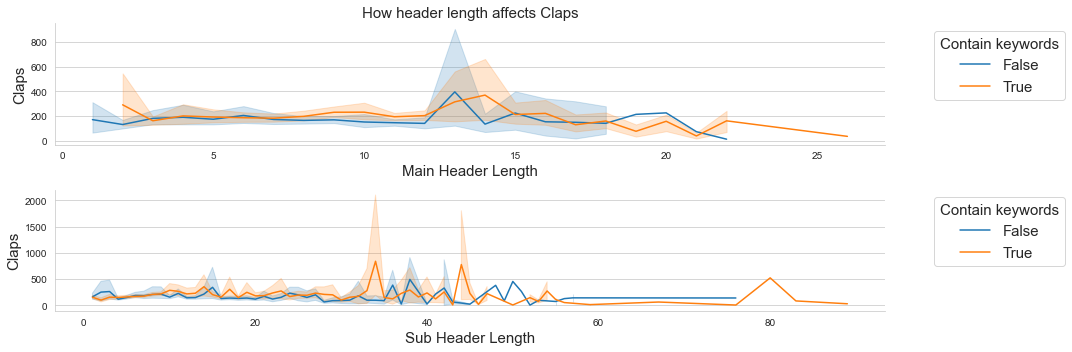

In [151]:
# temp3 = temp3.dropna()
df['avg_main_h_len'] = df.apply(lambda x:len(x['header'].split()),axis=1)
df['avg_sub_h_len'] = df.apply(lambda x:len(x['sub_header'].split()),axis=1)


fig,ax = plt.subplots(figsize=(15,5),nrows=2,ncols=1)
sns.lineplot(x='avg_main_h_len',y='clap',data=df.sort_values('avg_main_h_len'),ax=ax[0],hue='in_headers')
sns.lineplot(x='avg_sub_h_len',y='clap',data=df.sort_values('avg_sub_h_len'),ax=ax[1],hue='in_headers')

ax[0].set_xlabel('Main Header Length',fontdict={'fontsize':15})
ax[1].set_xlabel('Sub Header Length',fontdict={'fontsize':15})

ax[0].set_ylabel('Claps',fontdict={'fontsize':15})
ax[1].set_ylabel('Claps',fontdict={'fontsize':15})

ax[0].set_title('How header length affects Claps',fontdict={'fontsize':15});

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[0].grid(False,which='both',axis='x')
ax[1].grid(False,which='both',axis='x')


ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,title='Contain keywords',
           title_fontsize=15,fontsize=15);

ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,title='Contain keywords',
           title_fontsize=15,fontsize=15);

plt.tight_layout()
plt.savefig('plot8-1.jpg',dpi=100,bbox_inches='tight');


## Some observation.
> Main Header
* There is spikes of claps for headers containing 13 to 17 number of words. 

>Sub-Header
* An alternating movement is observed in between headers containing 30 to 50 words which stabilizes from 60 to the end.

The number of claps reduced after a word length of 20 in the main header and 60 in the sub-header.

**In conclusion, we can say that there is no specific merit in the header length you choose but you may consider choosing words between 14 to 17 for your main header and 30 to 50 words for your sub header.**

## 6. How does the reading time also affects the number of claps?
hypothesis:
The lesser the reading time the better.

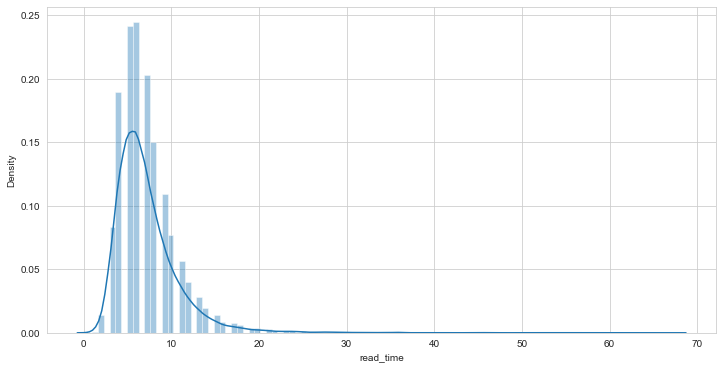

In [153]:
df = df[df['read_time'] != '--:--']
df['clap'] = df['clap'].astype('int')
df['read_time'] = df['read_time'].astype('int')

# Lets first of all check the distribution of the reading time
fig,ax = plt.subplots(figsize=(12,6))
sns.distplot(df['read_time'],bins=100);

* The reading time is positively skewed  
* Most content on medium have around 3 to 11 minutes read   

**NB** We will break the read time into four categories `[0-3,3-10,10-20,20-inf]`

In [154]:
df['read_time_cat'] = pd.cut(df['read_time'],[0,5,10,20,67],
       labels=['0-5 minutes','5-10 minutes','10-20 minutes','20 - 67 minutes'])

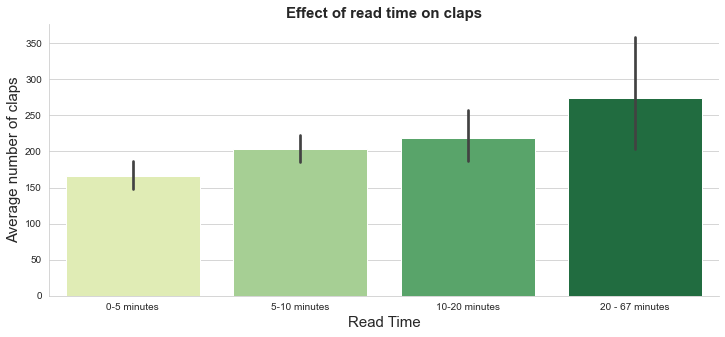

In [156]:
# Lets do the plotting
fig,ax = plt.subplots(figsize=(12,5))
sns.barplot(x='read_time_cat',y='clap',data=df,palette='YlGn')
plt.xlabel('Read Time',fontdict={'fontsize':15})
plt.ylabel('Average number of claps',fontdict={'fontsize':15});
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Effect of read time on claps',fontdict={'fontsize':15,'fontweight':'bold'});
# plt.setp(ax.get_xticklabels(),fontsize=15,rotation=-90);
plt.savefig('plot9.jpg',dpi=1200,bbox_inches='tight');


* From the initial distribution of the read time, it was observed that 87% of the articles have 2 to 10 minutes read time.
* Articles that falls in between 21-67 minutes reading time is observed to have the highest average number of claps, followed by the 10-20, 5-10 and 0-5 minutes.  

* Article with 5 to 20 minutes read time have equal chances of getting similar claps from readers.

#### Conclusion
* It is not adviceable to write short articles below 5 minutes read time.
* Also the above let us undertand that the lesser the reading time does not guarantee you an appreciation from your readers but rather arguabliy the quality of the content.   
Just know that every reader is ready to spend as much time on your article as long as it worth the time. So in as much as you try to save readers time, you must also priortize the quality of it.

> Another takeaway:
* I did a manual checking and I found out that most articles with higher reading time are either a top research work of interest or the post are coming from a tech giant such as Google or facebook.

## 7. Does the number of tags you choose contribute to your claps?
#### Let first of all, know the percentage distribution of posts on the various number of tags.


In [157]:
df['num_tag'] = df['tag'].apply(lambda x:len(x))
# percentage of articles each tag number has
np.round(df['num_tag'].value_counts(normalize=True)*100,2)

5    86.20
4     8.39
3     3.16
1     1.30
2     0.94
Name: num_tag, dtype: float64

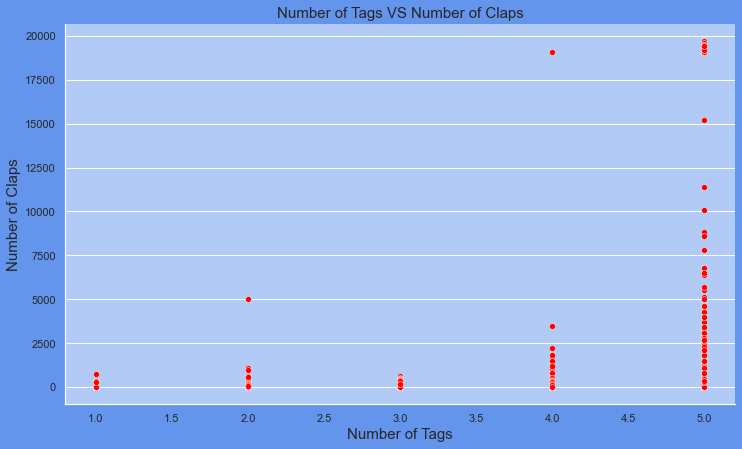

In [159]:
sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
fig,ax = plt.subplots(figsize=(12,7))

sns.scatterplot(x='num_tag',y='clap',data=df,color='red',estimator='mean')
plt.xlabel('Number of Tags',fontdict={'fontsize':15})
plt.ylabel('Number of Claps',fontdict={'fontsize':15})
ax.set_title('Number of Tags VS Number of Claps',fontdict={'fontsize':15})
ax.set_ylabel('Number of Claps',fontdict={'fontsize':15})
ax.set_xlabel('Number of Tags',fontdict={'fontsize':15})
ax.patch.set_facecolor('#ffffff')
ax.patch.set_alpha(0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.grid(False,which='both',axis='x')
ax.grid(False,which='both',axis='x')

# cmap = sns.cubehelix_palette(light=1,as_cmap=True)
# df_piv = pd.pivot_table(data=df,values='clap',index='read_time',columns='num_tag')
# sns.heatmap(df_piv,cmap=cmap,ax=ax[1])
# ax[1].set_title('Read time VS Number of Tags VS Number of Claps')

# ax[1].set_ylabel('Read time',fontdict={'fontsize':15})
# ax[1].set_xlabel('Number of Tags',fontdict={'fontsize':15})

# plt.tight_layout()

plt.savefig('plot10.jpg',dpi=1200,bbox_inches='tight');

The above is a clear indication of how choosing the number of tags to be used on your article is crucial.
* The plot depicts that, the more the number of tags, the more the claps.
    * This simply means that most medium readers follow medium based on topics.
    So in order for the medium SEO to gear your article to many readers following diverse topics, it is recommended to use many topics revolving around your article as tags.
    
* Also, there are no much difference between the articles with no tag through to those with 3 tags, but there is a significant change from 3 to 4 and 4 to 5.
* Moreover, it is recorded that $86.20$% of articles used $5$ tags, $8.39$ used $4$ tags,then the rest follows.
    * So it is recommended that you use at least $4$ tags on your post.

## 8. Should I embed several images to captivate readers interest in my post?

Hypothesis:  
There is a saying "A picture is worth a thousand words", so we are assuming that the more images you use in your post, the better the readers appreciation

In [160]:
# lets create a function to get us the number of images used in each article
def extract_images(article):
#     extract image urls
    links = re.search(r'https.+(.png|.jpg|.jpeg|.gif)',article)
    if links:
#         if the list is not empty, do the following
        links = links.group()
#         filter the links
        links = [link for link in links.split() if re.search(r'.*(.jpeg|.png|.jpg|.gif)',link)]
        links = [link.split('*')[-1] for link in links]
        links = set([link.replace('"','').lower() for link in links])
        return len(links)     
#         return links
    else:
        return len([])
    
    
# create a new column and name it as 'num_images'
df['num_images'] = df['article'].apply(lambda x:extract_images(x))

#### Lets do a simple correlation to know how the number of images in a post correlates with the number of claps

In [161]:
df[['num_images','clap']].corr().iloc[0,1]

0.02747466625523287

In [162]:
# create a categorical field that hold 'True' if article have at least an image and 'False' the otherwise
df['has_image'] = (df['num_images'] > 0)

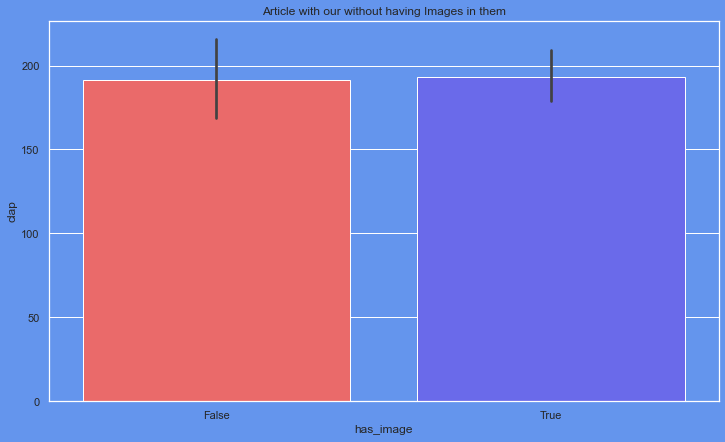

In [167]:
fig,ax = plt.subplots(figsize=(12,7))
sns.barplot(x='has_image',y='clap',data=df,palette='seismic_r')
ax.set_title('Article with our without having Images in them')
plt.savefig('plot11.jpg',dpi=1200,bbox_inches='tight');

* We had a very low correlation value of $0.03$.
> This means the number of images have little to no effect on the reader's level of appreciation.  
* Articles with and without images showed from the barplot to have equal average number of claps.

### Hence instead of embedding plenty images intending to drive readers interest, it is better to use it only when needed and necessary.

## 8.  Is the article's Date of publication a factor to win more readers interest?
Hypothesis:
* We can say that, the article's date of publication also have influence on its number of reads and claps.
* Articles published on weekends earns less claps.

**_Lets test our hypothesis._**

In [169]:
# Get day, weekday and month
df['day'] = pd.to_datetime(df['date_publish']).apply(lambda x:x.day)
df['weekday'] = pd.to_datetime(df['date_publish']).apply(lambda x:x.weekday())

df['month'] = pd.to_datetime(df['date_publish']).apply(lambda x:x.month)

day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df['weekday'] = df['weekday'].map(day_dict)

# month_dict = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',
#               10:'October',11:'November',12:'December'}

month_name = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
              'October', 'November', 'December']

# df['month'] = df['month'].map(month_dict)

### Month

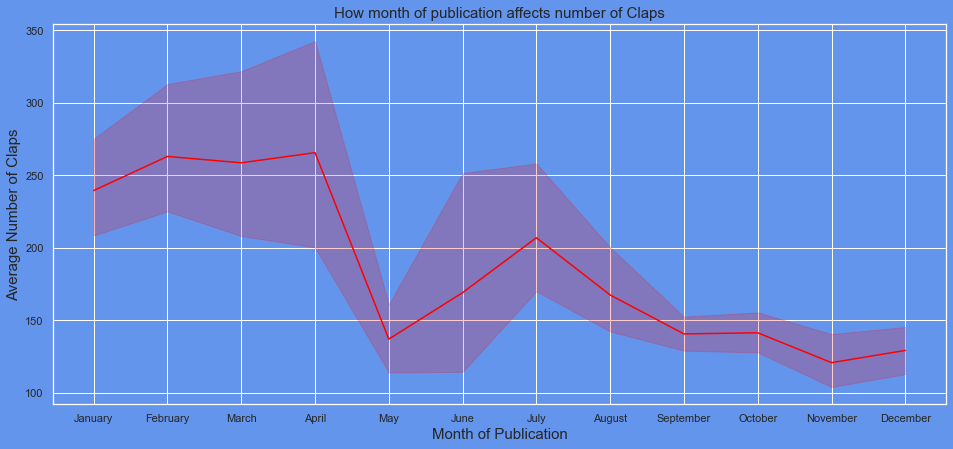

In [173]:
fig,ax = plt.subplots(figsize=(16,7))

sns.lineplot(x='month',y='clap',data=df.sort_values('month'),color='red')
ax.set_xticks(sorted(df['month'].unique()));
ax.set_xticklabels(month_name)
ax.set_title('How month of publication affects number of Claps',fontdict={'fontsize':15})
plt.xlabel('Month of Publication',fontdict={'fontsize':15})
plt.ylabel('Average Number of Claps',fontdict={'fontsize':15})
plt.savefig('plot12.jpg',dpi=100,bbox_inches='tight');

* Higher claps are observed from the Month of January to the middle of March.
* There is a steep decline in the number of claps from the middle of March to December.
> This decline can be attributed to the rapid surge of the pandemic since a [significant number of positive cases were recorded from the month of May/2020 going forward](https://www.worldometers.info/coronavirus/)

Due to this analogy, we can't confidently conclude on the month.

### Weekday

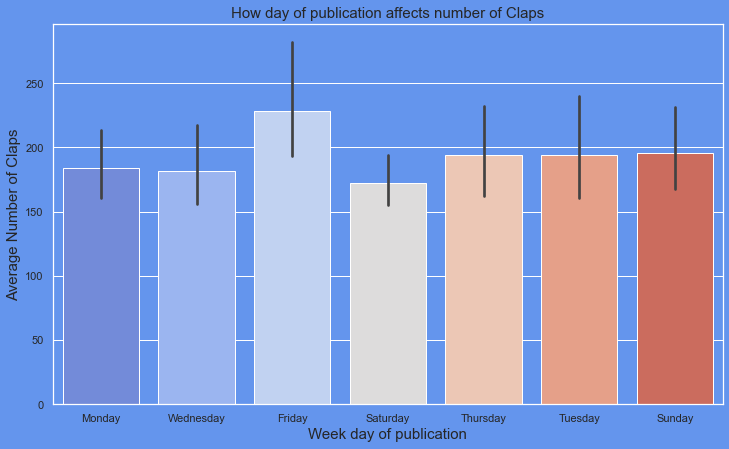

In [175]:
fig,ax = plt.subplots(figsize=(12,7))

sns.barplot(x='weekday',y='clap',data=df,palette='coolwarm')
ax.set_title('How day of publication affects number of Claps',fontdict={'fontsize':15})
plt.xlabel('Week day of publication',fontdict={'fontsize':15})
plt.ylabel('Average Number of Claps',fontdict={'fontsize':15})
plt.savefig('plot13.jpg',dpi=1200,bbox_inches='tight');

* Friday recorded the highest number of claps and in contrast the lowest clap is recorded on Saturday.
* So posting your article on saturday is not recommended as far as this findings is concern.

### Weekends

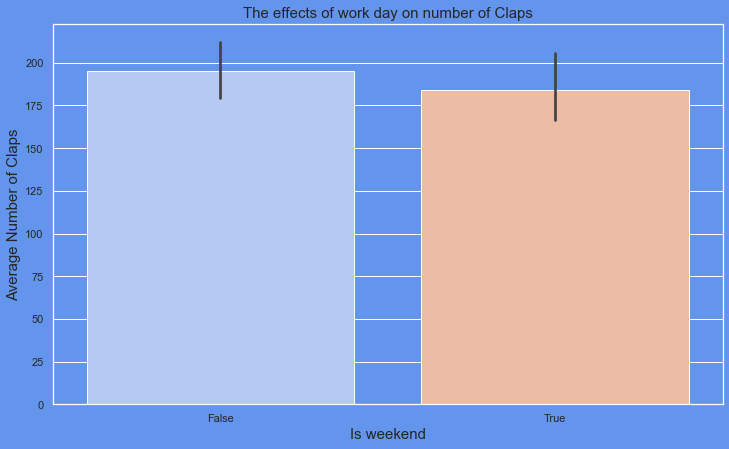

In [177]:
df['weekend'] = df['weekday'].isin(['Saturday','Sunday'])

fig,ax = plt.subplots(figsize=(12,7))

sns.barplot(x='weekend',y='clap',data=df,palette='coolwarm')
plt.xlabel('Is weekend',fontdict={'fontsize':15})
ax.set_title('The effects of work day on number of Claps',fontdict={'fontsize':15})
plt.ylabel('Average Number of Claps',fontdict={'fontsize':15})
plt.savefig('plot14.jpg',dpi=1200,bbox_inches='tight');

* There is a slight increase in the number of claps published on weekdays than on weekends.
So you may consider publishing your article on week days.